# コードのテスト
## tuning.optuna_train.py について
- optunaでハイパーパラメータチューニング

### tuning 系はoptuna(ハイパーパラメータ自動最適化ツール) 使うのでaaa0162ユーザのpy36環境でしか実行できない
- 実データは重いのでサンプルデータで確認

In [1]:
import os
gpu_num = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from tuning import optuna_train
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict

sys.path.append(r'/home/aaa00162/jupyterhub/notebook/other/lib_DL/optuna-master')
import optuna

import keras
import keras.backend as K
import numpy as np
import shutil
%matplotlib inline

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
optuna_train.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file


### 固定パラメータ
- バッチサイズ
- 出力ディレクトリ
- 画像サイズ: 100x100
- クラス数：5
- エポック数
- GPUの数
- 損失関数
- metrics
- 出力層の活性化関数: sigmoid（マルチラベルなので）
- 出力層の重みの初期値: zeros
- 出力層のl2: 1e-4
- FCのpooling方法: GlobalAveragePooling2D
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - #keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - #keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    - my_callback.tsv_logger: 各エポックの結果をtsvファイルに保存する

In [2]:
# batch_size
train_batch_size=100
valid_batch_size=100

# 出力ディレクトリ
out_dir = 'output_test_optuna/100x100'
os.makedirs(out_dir, exist_ok=True)

# 入力層のサイズ
shape=[100, 100, 3]

# クラス数
num_classes=5

# エポック数
epochs=2

# GPUの数
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# 損失関数
loss = multi_loss.build_masked_loss(K.binary_crossentropy) 

# metrics
metrics = ['binary_accuracy', multi_loss.masked_accuracy]

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# pooling方法
FCpool='GlobalAveragePooling2D'

# callback
cb_base = []
if gpu_count > 1:
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb_base.append(keras.callbacks.TerminateOnNaN())
    # keras.callbacks.EarlyStopping
    early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
    early_stopping_pati=10
    cb_base.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati, verbose=1))
    
# 学習率をエポック増やすごとにコサインカーブのように上げ下げする
## 引数なしならlr*0.01まで下げるだけ
#cb_base.append(my_callback.cosine_annealing())

cb_base.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
cb_base.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))
print(cb_base)

gpu_count: 1
[<keras.callbacks.TerminateOnNaN object at 0x7fe53d13aef0>, <keras.callbacks.EarlyStopping object at 0x7fe53d13af28>, <keras.callbacks.CSVLogger object at 0x7fe53d125b00>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x7fe53d13af98>]


## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

(1600, 100, 100, 3)
(400, 100, 100, 3)


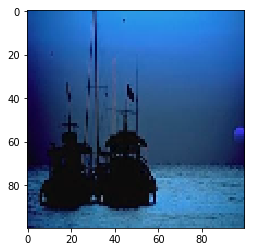

In [3]:
# Downloading and Viewing the dataset
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File(r"/gpfsx01/home/aaa00162/jupyterhub/notebook/work_H3-038/work/03.Tox21_work_refine/experiment/01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()
plt.imshow(x_train[0])
print(x_train.shape)
print(x_test.shape)

### データ管理クラス定義
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import sys
# /home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator
sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

### Dataset management class
class LabeledDataset:
    """
    データ管理用クラス
    cpuのメモリに全画像データを持つのでcpuのメモリ少ない場合は使えないかも
    """
    def __init__(self, shape, train_batch_size, valid_batch_size, X_train, y_train, X_valid, y_valid):
        self.shape = shape
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
    
    def create_generator(self, use_mixup=False, IDG_options={}):
        """trainとvalidationのImageDataGenerator作成"""
        print('----- train_ImageDataGenerator -----')
        print('use_mixup:', use_mixup)
        print('IDG_options:', IDG_options)
        aug_datagen = ImageDataGenerator(**IDG_options)
        if use_mixup:
            # ラベルに-1が混じってるからMixup使うと、ラベルも混ぜるのでlossがマイナスになる
            # 今回はMixupつかえない
            self.train_gen = MixupGenerator(self.X_train, self.y_train, alpha=1.0, batch_size=self.train_batch_size, datagen=aug_datagen)()
        else:
            self.train_gen = aug_datagen.flow(self.X_train, self.y_train, batch_size=self.train_batch_size)
        plain_datagen = ImageDataGenerator()
        self.valid_gen = plain_datagen.flow(self.X_valid, self.y_valid, batch_size=self.valid_batch_size, shuffle=False)
        return self.train_gen, self.valid_gen
    
    def train_steps_per_epoch(self):
        """fit_generatorで指定するtrainのsteps_per_epoch"""
        return len(self.X_train) // self.train_batch_size
    
    def valid_steps_per_epoch(self):
        """fit_generatorで指定するvalidationのsteps_per_epoch"""
        return len(self.X_valid) // self.valid_batch_size
    
d_cls = LabeledDataset(shape, train_batch_size, valid_batch_size, x_train, y_train, x_test, y_test)

### 目的関数の定義
#### チューニング可能パラメータ
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル
    - fine-tuning
    - 全結合0-5層（重みの初期値はhe_normal(He の正規分布)で固定）
        - ユニット数 (同じ値か層ごとに減らす)
        - dropout_rate (全層同じ値になる)
        - Batch_Normalization (全層同じ値になる)
        - l2正則化(weight decay) (全層同じ値になる)
- オプティマイザ
- 学習率
    - 学習率変更なし
    - cosine_annealing(factor=0.01, epochs=None)
    - LearningRateScheduler(lr* 1/4 を3回する)
- データ水増し( keras.preprocessing.image.ImageDataGenerator )
    - 画像の剪断(shear)
    - 拡大縮小(zoom)
    - 回転(rotation)
    - 上下反転(vertical_flip)
    - 左右反転(horizontal_flip)
    - 画像の一部矩形領域を隠す（random_erasing)
    - 画像混ぜる(mix_up)

In [5]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16','InceptionV3','Xception','NASNetLarge','SEInceptionV3','SEInceptionResNetV2']# 学習済みモデル 
trainable = ['all', 16] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [0,1,2,3,4,5] # FC層の数 
Dence = [1024, 512, 256, 128] # FC層のユニット数
Dropout = [0.0, 0.5, 0.7] # FC層のDropout
addBatchNorm = [None, 'add'] # FC層のBatchNorm
l2 = [0.0, 1e-4, 1e-2] # FC層のl2
choice_optim = ['sgd', 'adam', 'nadam'] # optimizer
lr = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # （初期）学習率
callback_lr = [None, 'cosine_annealing'] # 学習率変更するcallback
callback_save_model=True # モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(out_dir, 'model_weight_optuna')
    if os.path.exists(model_dir) == True:
        shutil.rmtree(model_dir) # モデルディレクトリすでにあれば一旦削除

## ImageDataGenerator param
horizontal_flip=[True, False] # 画像の左右反転
vertical_flip=[True, False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0 
rotation_range_max=180
rotation_unit=10 # 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.1
zoom_range_low_max=1.0
zoom_range_high_min=1.0
zoom_range_high_max=1.9
zoom_range_unit=0.1 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=0.0
shear_range_max=0.5
shear_range_unit=0.1 # 0.0 にしたら shear_range_max で固定
random_eraser_flg= [True, False] # Random Erasing 含めるか
pixel_min=np.min(d_cls.X_train) # Random Erasing で使う画素数の最小値
pixel_max=np.max(d_cls.X_train) # Random Erasing で使う画像数の最大値（1/255で割ってるはずだから基本1.0）
use_mixup=[True, False] # mixup 含めるか

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , horizontal_flip=horizontal_flip
                                   , vertical_flip=vertical_flip
                                   , rotation_range_min=rotation_range_min
                                   , rotation_range_max=rotation_range_max
                                   , rotation_unit=rotation_unit
                                   , zoom_range_low_min=zoom_range_low_min
                                   , zoom_range_low_max=zoom_range_low_max
                                   , zoom_range_high_min=zoom_range_high_min
                                   , zoom_range_high_max=zoom_range_high_max
                                   , zoom_range_unit=zoom_range_unit
                                   , shear_range_min=shear_range_min
                                   , shear_range_max=shear_range_max
                                   , shear_range_unit=shear_range_unit
                                   , random_eraser_flg=random_eraser_flg
                                   , pixel_min=pixel_min
                                   , pixel_max=pixel_max
                                   , use_mixup=use_mixup
                                  )

### 最適化の実行

In [6]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=2)# 100

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = NASNetLarge all
FCnum = 5
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.01
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.5 None he_normal 0.01
dence dropout addBatchNorm kernel_initializer l2_rate = 576 0.5 None he_normal 0.01
dence dropout addBatchNorm kernel_initializer l2_rate = 576 0.5 None he_normal 0.01
dence dropout addBatchNorm kernel_initializer l2_rate = 288 0.5 None he_normal 0.01
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': -0.0, 'zoom_range': [0.2, 1.2000000000000002], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7fe501426d08>}
Epoch 00001: val_loss improved from inf to 51.01343, saving model to output_test_optuna/100x100/model_weight_optuna/0.h5
Epoch 00002: val_loss improved from 51.01343 to 50.44

[I 2018-12-28 13:42:23,164] Finished a trial resulted in value: 50.44672203063965. Current best value is 50.44672203063965 with parameters: {'choice_model': 'NASNetLarge', 'trainable': 'all', 'FCnum': 5, 'Dence_1': 1024, 'Dropout': 0.5, 'addBatchNorm': None, 'l2': 0.01, 'Dence_2': 768.0, 'Dence_3': 576.0, 'Dence_4': 576.0, 'Dence_5': 288.0, 'lr': 0.01, 'choice_optim': 'sgd', 'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': -0.0, 'zoom_range_low': 0.2, 'zoom_range_high': 1.2000000000000002, 'shear_range': 0.2, 'random_eraser_flg': True, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': 'cosine_annealing'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEInceptionV3 16
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = nadam ----
nadam_lr nadam_schedule_decay beta_1 beta_2 = 0.002 0.004 0.9 0.999
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 90.0, 'zoom_range': [0.4, 1.3], 'shear_range': 0.1, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7fe43d79f510>}
Epoch 00001: val_loss improved from inf to 0.65647, saving model to output_test_optuna/100x100/model_weight_optuna/1.h5
Epoch 00002: val_loss improved from 0.65647 to 0.62796, saving model to output_test_optuna/100x100/model_weight_optuna/1.h5


[I 2018-12-28 13:43:54,821] Finished a trial resulted in value: 0.6279570162296295. Current best value is 0.6279570162296295 with parameters: {'choice_model': 'SEInceptionV3', 'trainable': 16, 'FCnum': 0, 'lr': 0.0, 'choice_optim': 'nadam', 'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 90.0, 'zoom_range_low': 0.4, 'zoom_range_high': 1.3, 'shear_range': 0.1, 'random_eraser_flg': True, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': None}.


CPU times: user 9min 11s, sys: 19.5 s, total: 9min 31s
Wall time: 8min 48s


### 結果の確認

In [9]:
# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる

study.best_params

{'choice_model': 'SEInceptionV3',
 'trainable': 16,
 'FCnum': 0,
 'lr': 0.0,
 'choice_optim': 'nadam',
 'horizontal_flip': True,
 'vertical_flip': True,
 'rotation_range': 90.0,
 'zoom_range_low': 0.4,
 'zoom_range_high': 1.3,
 'shear_range': 0.1,
 'random_eraser_flg': True,
 'use_mixup': True,
 'branch_Tox21_12task': False,
 'callback_lr': None}

In [10]:
# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

trial_id                state      value             datetime_start  \
                                                                        
0        0  TrialState.COMPLETE  50.446722 2018-12-28 13:35:06.032151   
1        1  TrialState.COMPLETE   0.627957 2018-12-28 13:42:23.165678   

           datetime_complete  params                                  \
                             Dence_1 Dence_2 Dence_3 Dence_4 Dence_5   
0 2018-12-28 13:42:23.163492  1024.0   768.0   576.0   576.0   288.0   
1 2018-12-28 13:43:54.820964     NaN     NaN     NaN     NaN     NaN   

     ...      user_attrs                                                      \
     ...     num_classes                     out_dir pred_kernel_initializer   
0    ...               5  output_test_optuna/100x100                   zeros   
1    ...               5  output_test_optuna/100x100                   zeros   

                                                                     \
  pred_l2_rate          shape                                  uuid   
0       0.0001  [100, 100, 3]  db645a08-81cb-48e6-a7f9-d30039706c98   
1       0.0001  [100, 100, 3]  8145c488-63c9-41ea-bc46-979df584a98f   

                                 intermediate_values             
  val_binary_accuracy   val_loss                   0          1  
0              0.2475  50.446722          -50.013434 -49.446722  
1              0.2475   0.627957            0.343532   0.372043  

[2 rows x 45 columns]

## 細かく確認

### 引数最小限で実行

In [9]:
%%time
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                  )


sqlite_log_path = 'sqlite:///'+out_dir+'/example.db'
if os.path.exists(sqlite_log_path) == True:
    os.remove(sqlite_log_path) # sqlite 履歴ファイルすでにあれば一旦削除
# sqlite 使って履歴ファイル作る
study = optuna.create_study(study_name='example-study', storage=sqlite_log_path)
study = optuna.create_study()
study.optimize(objective, n_trials=5)# 100

# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
print(study.best_params)

# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = Xception all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
---- choice_optim = adadelta ----
adadelta_lr adadelta_decay adadelta_rho = 1.0 0.0 0.95
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range': [0.5, 1.6], 'shear_range': -0.0}


[I 2018-12-28 13:18:12,615] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'Xception', 'trainable': 'all', 'FCnum': 0, 'lr': 0.0, 'choice_optim': 'adadelta', 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range_low': 0.5, 'zoom_range_high': 1.6, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': 'LearningRateScheduler'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = InceptionV3 249
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.7 add he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.7 add he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.7 add he_normal 0.0001
---- choice_optim = adadelta ----
adadelta_lr adadelta_decay adadelta_rho = 0.01 0.0 0.95
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': False, 'vertical_flip': True, 'rotation_range': 10.0, 'zoom_range': [0.8, 1.8], 'shear_range': -0.3}


[I 2018-12-28 13:18:51,912] Finished a trial resulted in value: 1.088951051235199. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'Xception', 'trainable': 'all', 'FCnum': 0, 'lr': 0.0, 'choice_optim': 'adadelta', 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range_low': 0.5, 'zoom_range_high': 1.6, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': 'LearningRateScheduler'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEInceptionV3 all
FCnum = 4
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 256 0.5 add he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 add he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 add he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 96 0.5 add he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0001 0.9 0.0 True
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0.0, 'zoom_range': [1.0, 1.5], 'shear_range': 0.3}


[I 2018-12-28 13:19:34,979] Finished a trial resulted in value: 0.7867554724216461. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'Xception', 'trainable': 'all', 'FCnum': 0, 'lr': 0.0, 'choice_optim': 'adadelta', 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range_low': 0.5, 'zoom_range_high': 1.6, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': 'LearningRateScheduler'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = ResNet50 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


[W 2018-12-28 13:19:37,096] Setting trial status as TrialState.FAIL because of the following error: ValueError("Negative dimension size caused by subtracting 7 from 3 for 'avg_pool/AvgPool' (op: 'AvgPool') with input shapes: [?,3,3,2048].",)
Traceback (most recent call last):
  File "/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/common_shapes.py", line 686, in _call_cpp_shape_fn_impl
    input_tensors_as_shapes, status)
  File "/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 3 for 'avg_pool/AvgPool' (op: 'AvgPool') with input shapes: [?,3,3,2048].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aaa00162/jupyterhub/notebook/other/lib_DL/optuna-

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = ResNet50 249
FCnum = 2
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


[W 2018-12-28 13:19:41,239] Setting trial status as TrialState.FAIL because of the following error: ValueError("Negative dimension size caused by subtracting 7 from 3 for 'avg_pool/AvgPool' (op: 'AvgPool') with input shapes: [?,3,3,2048].",)
Traceback (most recent call last):
  File "/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/common_shapes.py", line 686, in _call_cpp_shape_fn_impl
    input_tensors_as_shapes, status)
  File "/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 473, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: Negative dimension size caused by subtracting 7 from 3 for 'avg_pool/AvgPool' (op: 'AvgPool') with input shapes: [?,3,3,2048].

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aaa00162/jupyterhub/notebook/other/lib_DL/optuna-

{'choice_model': 'Xception', 'trainable': 'all', 'FCnum': 0, 'lr': 0.0, 'choice_optim': 'adadelta', 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range_low': 0.5, 'zoom_range_high': 1.6, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'branch_Tox21_12task': False, 'callback_lr': 'LearningRateScheduler'}
CPU times: user 2min 29s, sys: 10.8 s, total: 2min 39s
Wall time: 2min 11s


In [ ]:
study = optuna.Study(study_name='example-study', storage=sqlite_log_path)
df = study.trials_dataframe()
df

### リストの引数を1つだけで実行

In [10]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16']# 学習済みモデル 
trainable = ['all'] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [3] # FC層の数 
Dence = [1024] # FC層のユニット数
Dropout = [0.0] # FC層のDropout
addBatchNorm = ['add'] # FC層のBatchNorm
l2 = [0.0] # FC層のl2
choice_optim = ['rmsprop'] # optimizer
lr = [0.0] # （初期）学習率
callback_lr = ['LearningRateScheduler'] # 学習率変更するcallback
callback_save_model = False # モデル保存するcallback つけるか. False なら保存しない

## ImageDataGenerator param
horizontal_flip=[True] # 画像の左右反転
vertical_flip=[False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0 
rotation_range_max=90
rotation_unit=1 # 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.9
zoom_range_low_max=1.0
zoom_range_high_min=1.0
zoom_range_high_max=1.2
zoom_range_unit=0.05 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=0.1
shear_range_max=0.8
shear_range_unit=0.2 # 0.0 にしたら shear_range_max で固定
random_eraser_flg= [True] # Random Erasing 含めるか
pixel_min=np.min(d_cls.X_train) # Random Erasing で使う画素数の最小値
pixel_max=np.max(d_cls.X_train) # Random Erasing で使う画像数の最大値（1/255で割ってるはずだから基本1.0）
use_mixup=[True] # mixup 含めるか

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , horizontal_flip=horizontal_flip
                                   , vertical_flip=vertical_flip
                                   , rotation_range_min=rotation_range_min
                                   , rotation_range_max=rotation_range_max
                                   , rotation_unit=rotation_unit
                                   , zoom_range_low_min=zoom_range_low_min
                                   , zoom_range_low_max=zoom_range_low_max
                                   , zoom_range_high_min=zoom_range_high_min
                                   , zoom_range_high_max=zoom_range_high_max
                                   , zoom_range_unit=zoom_range_unit
                                   , shear_range_min=shear_range_min
                                   , shear_range_max=shear_range_max
                                   , shear_range_unit=shear_range_unit
                                   , random_eraser_flg=random_eraser_flg
                                   , pixel_min=pixel_min
                                   , pixel_max=pixel_max
                                   , use_mixup=use_mixup
                                  )
study = optuna.create_study()
study.optimize(objective, n_trials=5)# 100

# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w')
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
print(study.best_params)

# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range': [0.9, 1.1500000000000001], 'shear_range': 0.8, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b8e6c5f28>}
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9


[I 2018-12-27 15:33:47,522] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 576 0.0 add he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 59.0, 'zoom_range': [0.9, 1.05], 'shear_range': 0.8, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b8e4327b8>}
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9


[I 2018-12-27 15:34:14,756] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 62.0, 'zoom_range': [1.0, 1.1], 'shear_range': 0.4, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b8adc0598>}
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9


[I 2018-12-27 15:34:41,994] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 20.0, 'zoom_range': [0.9500000000000001, 1.2], 'shear_range': 0.4, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b885d0400>}
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9


[I 2018-12-27 15:35:09,231] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 768 0.0 add he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 7.0, 'zoom_range': [1.0, 1.2], 'shear_range': 0.6000000000000001, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b898536a8>}
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9


[I 2018-12-27 15:35:36,390] Finished a trial resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}.


{'choice_model': 'VGG16', 'trainable': 'all', 'FCnum': 3, 'Dence_1': 1024, 'Dropout': 0.0, 'addBatchNorm': 'add', 'l2': 0.0, 'Dence_2': 768.0, 'Dence_3': 768.0, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 24.0, 'zoom_range_low': 0.9, 'zoom_range_high': 1.1500000000000001, 'shear_range': 0.8, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 0.0, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'rmsprop'}


trial_id                state     value             datetime_start  \
                                                                       
0        0  TrialState.COMPLETE  0.693147 2018-12-27 15:33:19.233700   
1        1  TrialState.COMPLETE  0.693147 2018-12-27 15:33:47.523857   
2        2  TrialState.COMPLETE  0.693147 2018-12-27 15:34:14.757621   
3        3  TrialState.COMPLETE  0.693147 2018-12-27 15:34:41.995442   
4        4  TrialState.COMPLETE  0.693147 2018-12-27 15:35:09.232578   

           datetime_complete  params                                  ...     \
                             Dence_1 Dence_2 Dence_3 Dropout FCnum    ...      
0 2018-12-27 15:33:47.521999    1024   768.0   768.0     0.0     3    ...      
1 2018-12-27 15:34:14.755353    1024   768.0   576.0     0.0     3    ...      
2 2018-12-27 15:34:41.992841    1024   768.0   768.0     0.0     3    ...      
3 2018-12-27 15:35:09.229866    1024  1024.0   768.0     0.0     3    ...      
4 2018-12-27 15:35:36.388653    1024   768.0   768.0     0.0     3    ...      

  user_attrs                                                                 \
        loss                                            metrics num_classes   
0   0.693147  ['binary_accuracy', <function masked_accuracy ...           5   
1   0.693147  ['binary_accuracy', <function masked_accuracy ...           5   
2   0.693147  ['binary_accuracy', <function masked_accuracy ...           5   
3   0.693147  ['binary_accuracy', <function masked_accuracy ...           5   
4   0.693147  ['binary_accuracy', <function masked_accuracy ...           5   

                                                                    \
                      out_dir pred_kernel_initializer pred_l2_rate   
0  output_test_optuna/100x100                   zeros       0.0001   
1  output_test_optuna/100x100                   zeros       0.0001   
2  output_test_optuna/100x100                   zeros       0.0001   
3  output_test_optuna/100x100                   zeros       0.0001   
4  output_test_optuna/100x100                   zeros       0.0001   

                                                                            \
           shape                                  uuid val_binary_accuracy   
0  [100, 100, 3]  88098730-738f-40d1-8438-ceb8fd3e55b5              0.2475   
1  [100, 100, 3]  41bcc795-130a-4bf2-8752-16d733431399              0.2475   
2  [100, 100, 3]  7f7cd4d4-e8fa-4c32-a80e-a7d7e8354e3f              0.2475   
3  [100, 100, 3]  ddfa532c-0fbd-4fe1-b221-e4532af60463              0.2475   
4  [100, 100, 3]  735d7db3-f1f1-4f31-bcbf-6e3277624bc7              0.2475   

             
   val_loss  
0  0.693147  
1  0.693147  
2  0.693147  
3  0.693147  
4  0.693147  

[5 rows x 40 columns]

### rotation_range 
- rotation_range_max で固定してるか確認

In [11]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['InceptionV3']# 学習済みモデル 
trainable = ['all', 249] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [0,1,3] # FC層の数 
Dence = [1024, 512] # FC層のユニット数
Dropout = [0.0, 0.5] # FC層のDropout
addBatchNorm = [None] # FC層のBatchNorm
l2 = [0.0, 1e-6] # FC層のl2
choice_optim = ['adagrad', 'adamax'] # optimizer
lr = [0.0, 1e-5, 1e-8] # （初期）学習率
callback_lr = [None, 'cosine_annealing', 'LearningRateScheduler'] # 学習率変更するcallback
callback_save_model = False # モデル保存するcallback つけるか. False なら保存しない

## ImageDataGenerator param
horizontal_flip=[True] # 画像の左右反転
vertical_flip=[False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0 
rotation_range_max=0
rotation_unit=0.0 # 0.0 にしたら rotation_range_max で固定

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , horizontal_flip=horizontal_flip
                                   , vertical_flip=vertical_flip
                                   , rotation_range_min=rotation_range_min
                                   , rotation_range_max=rotation_range_max
                                   , rotation_unit=rotation_unit
                                  )
study = optuna.create_study()
study.optimize(objective, n_trials=3)# 100

# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w')
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
print(study.best_params)

# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = InceptionV3 249
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 512 0.0 None he_normal 1e-06
dence dropout addBatchNorm kernel_initializer l2_rate = 512 0.0 None he_normal 1e-06
dence dropout addBatchNorm kernel_initializer l2_rate = 384 0.0 None he_normal 1e-06
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0, 'zoom_range': [0.4, 1.7000000000000002], 'shear_range': 0.0}
---- choice_optim = adagrad ----
adagrad_lr adagrad_decay = 1e-05 0.0


[I 2018-12-27 15:36:18,976] Finished a trial resulted in value: 0.6938590109348297. Current best value is 0.6938590109348297 with parameters: {'choice_model': 'InceptionV3', 'trainable': 249, 'FCnum': 3, 'Dence_1': 512, 'Dropout': 0.0, 'addBatchNorm': None, 'l2': 1e-06, 'Dence_2': 512.0, 'Dence_3': 384.0, 'horizontal_flip': True, 'vertical_flip': False, 'zoom_range_low': 0.4, 'zoom_range_high': 1.7000000000000002, 'shear_range': 0.0, 'random_eraser_flg': False, 'use_mixup': True, 'lr': 1e-05, 'callback_lr': 'LearningRateScheduler', 'choice_optim': 'adagrad'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = InceptionV3 249
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 512 0.0 None he_normal 1e-06
dence dropout addBatchNorm kernel_initializer l2_rate = 384 0.0 None he_normal 1e-06
dence dropout addBatchNorm kernel_initializer l2_rate = 288 0.0 None he_normal 1e-06
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0, 'zoom_range': [0.6000000000000001, 1.3], 'shear_range': 0.30000000000000004, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4b73a98400>}
---- choice_optim = adagrad ----
adagrad_lr adagrad_decay = 1e-05 0.0


[I 2018-12-27 15:36:53,935] Finished a trial resulted in value: 0.6934700161218643. Current best value is 0.6934700161218643 with parameters: {'choice_model': 'InceptionV3', 'trainable': 249, 'FCnum': 3, 'Dence_1': 512, 'Dropout': 0.0, 'addBatchNorm': None, 'l2': 1e-06, 'Dence_2': 384.0, 'Dence_3': 288.0, 'horizontal_flip': True, 'vertical_flip': False, 'zoom_range_low': 0.6000000000000001, 'zoom_range_high': 1.3, 'shear_range': 0.30000000000000004, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 1e-05, 'callback_lr': None, 'choice_optim': 'adagrad'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = InceptionV3 all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 0, 'zoom_range': [0.1, 1.4000000000000001], 'shear_range': -0.0}
---- choice_optim = adagrad ----
adagrad_lr adagrad_decay = 1e-05 0.0


[I 2018-12-27 15:37:33,991] Finished a trial resulted in value: 0.6841050386428833. Current best value is 0.6841050386428833 with parameters: {'choice_model': 'InceptionV3', 'trainable': 'all', 'FCnum': 0, 'horizontal_flip': True, 'vertical_flip': False, 'zoom_range_low': 0.1, 'zoom_range_high': 1.4000000000000001, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'lr': 1e-05, 'callback_lr': None, 'choice_optim': 'adagrad'}.


{'choice_model': 'InceptionV3', 'trainable': 'all', 'FCnum': 0, 'horizontal_flip': True, 'vertical_flip': False, 'zoom_range_low': 0.1, 'zoom_range_high': 1.4000000000000001, 'shear_range': -0.0, 'random_eraser_flg': False, 'use_mixup': True, 'lr': 1e-05, 'callback_lr': None, 'choice_optim': 'adagrad'}


trial_id                state     value             datetime_start  \
                                                                       
0        0  TrialState.COMPLETE  0.693859 2018-12-27 15:35:36.450983   
1        1  TrialState.COMPLETE  0.693470 2018-12-27 15:36:18.978062   
2        2  TrialState.COMPLETE  0.684105 2018-12-27 15:36:53.936357   

           datetime_complete  params                                  ...     \
                             Dence_1 Dence_2 Dence_3 Dropout FCnum    ...      
0 2018-12-27 15:36:18.975526   512.0   512.0   384.0     0.0     3    ...      
1 2018-12-27 15:36:53.933659   512.0   384.0   288.0     0.0     3    ...      
2 2018-12-27 15:37:33.990188     NaN     NaN     NaN     NaN     0    ...      

                                          user_attrs              \
                                             metrics num_classes   
0  ['binary_accuracy', <function masked_accuracy ...           5   
1  ['binary_accuracy', <function masked_accuracy ...           5   
2  ['binary_accuracy', <function masked_accuracy ...           5   

                                                                    \
                      out_dir pred_kernel_initializer pred_l2_rate   
0  output_test_optuna/100x100                   zeros       0.0001   
1  output_test_optuna/100x100                   zeros       0.0001   
2  output_test_optuna/100x100                   zeros       0.0001   

                                                                       \
  rotation_range          shape                                  uuid   
0              0  [100, 100, 3]  a020c717-2237-464c-b583-e5acf0703f11   
1              0  [100, 100, 3]  3737a577-dd37-487a-a678-d3269f0190a4   
2              0  [100, 100, 3]  24451415-f3cd-4087-9954-b062528260af   

                                 
  val_binary_accuracy  val_loss  
0              0.2475  0.693859  
1              0.2475  0.693470  
2              0.2475  0.684105  

[3 rows x 40 columns]

### zoom_range 
- zoom_range_low_min, zoom_range_high_max で固定してるか確認

In [12]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16']# 学習済みモデル 
trainable = ['all', 16] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [0, 3] # FC層の数 
Dence = [1024, 128] # FC層のユニット数
Dropout = [0.0,0.3] # FC層のDropout
addBatchNorm = [None] # FC層のBatchNorm
l2 = [1e-3, 1e-8] # FC層のl2
choice_optim = ['adadelta','adamax'] # optimizer
lr = [0.0, 1.0] # （初期）学習率
callback_lr = ['cosine_annealing'] # 学習率変更するcallback
callback_save_model = False # モデル保存するcallback つけるか. False なら保存しない

## ImageDataGenerator param
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=1.0
zoom_range_low_max=1.0
zoom_range_high_min=1.0
zoom_range_high_max=1.0
zoom_range_unit=0.0 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , zoom_range_low_min=zoom_range_low_min
                                   , zoom_range_low_max=zoom_range_low_max
                                   , zoom_range_high_min=zoom_range_high_min
                                   , zoom_range_high_max=zoom_range_high_max
                                   , zoom_range_unit=zoom_range_unit
                                  )
study = optuna.create_study()
study.optimize(objective, n_trials=3)# 100

# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w')
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
print(study.best_params)

# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 16
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': 10.0, 'zoom_range': [1.0, 1.0], 'shear_range': 0.0, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4c05cb38c8>}
---- choice_optim = adadelta ----
adadelta_lr adadelta_decay adadelta_rho = 1.0 0.0 0.95


[I 2018-12-27 15:37:46,221] Finished a trial resulted in value: 0.5428643524646759. Current best value is 0.5428643524646759 with parameters: {'choice_model': 'VGG16', 'trainable': 16, 'FCnum': 0, 'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': 10.0, 'shear_range': 0.0, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 1.0, 'callback_lr': 'cosine_annealing', 'choice_optim': 'adadelta'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 16
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.0 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.0 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 64 0.0 None he_normal 0.001
----- train_ImageDataGenerator -----
use_mixup: True
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': -0.0, 'zoom_range': [1.0, 1.0], 'shear_range': 0.4, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4c05306f28>}
---- choice_optim = adamax ----
adamax_lr adamax_decay beta_1 beta_2 = 0.002 0.0 0.9 0.999


[I 2018-12-27 15:37:58,087] Finished a trial resulted in value: 0.9489016681909561. Current best value is 0.5428643524646759 with parameters: {'choice_model': 'VGG16', 'trainable': 16, 'FCnum': 0, 'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': 10.0, 'shear_range': 0.0, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 1.0, 'callback_lr': 'cosine_annealing', 'choice_optim': 'adadelta'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 16
FCnum = 3
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.0 None he_normal 1e-08
dence dropout addBatchNorm kernel_initializer l2_rate = 64 0.0 None he_normal 1e-08
dence dropout addBatchNorm kernel_initializer l2_rate = 32 0.0 None he_normal 1e-08
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 160.0, 'zoom_range': [1.0, 1.0], 'shear_range': 0.5, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4c06af7730>}
---- choice_optim = adadelta ----
adadelta_lr adadelta_decay adadelta_rho = 1.0 0.0 0.95


[I 2018-12-27 15:38:10,016] Finished a trial resulted in value: 0.5995873510837555. Current best value is 0.5428643524646759 with parameters: {'choice_model': 'VGG16', 'trainable': 16, 'FCnum': 0, 'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': 10.0, 'shear_range': 0.0, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 1.0, 'callback_lr': 'cosine_annealing', 'choice_optim': 'adadelta'}.


{'choice_model': 'VGG16', 'trainable': 16, 'FCnum': 0, 'horizontal_flip': False, 'vertical_flip': False, 'rotation_range': 10.0, 'shear_range': 0.0, 'random_eraser_flg': True, 'use_mixup': True, 'lr': 1.0, 'callback_lr': 'cosine_annealing', 'choice_optim': 'adadelta'}


trial_id                state     value             datetime_start  \
                                                                       
0        0  TrialState.COMPLETE  0.542864 2018-12-27 15:37:34.046748   
1        1  TrialState.COMPLETE  0.948902 2018-12-27 15:37:46.223272   
2        2  TrialState.COMPLETE  0.599587 2018-12-27 15:37:58.088217   

           datetime_complete  params                                \
                             Dence_1 Dence_2 Dence_3 Dropout FCnum   
0 2018-12-27 15:37:46.221096     NaN     NaN     NaN     NaN     0   
1 2018-12-27 15:37:58.085599   128.0   128.0    64.0     0.0     3   
2 2018-12-27 15:38:10.015275   128.0    64.0    32.0     0.0     3   

       ...                                               user_attrs  \
       ...                                                  metrics   
0      ...        ['binary_accuracy', <function masked_accuracy ...   
1      ...        ['binary_accuracy', <function masked_accuracy ...   
2      ...        ['binary_accuracy', <function masked_accuracy ...   

                                                                   \
  num_classes                     out_dir pred_kernel_initializer   
0           5  output_test_optuna/100x100                   zeros   
1           5  output_test_optuna/100x100                   zeros   
2           5  output_test_optuna/100x100                   zeros   

                                                                     \
  pred_l2_rate          shape                                  uuid   
0       0.0001  [100, 100, 3]  cb2f6e2b-18be-4cb8-8c9a-7aa4de93c212   
1       0.0001  [100, 100, 3]  42924f21-00f4-486d-a487-93a40b98fd13   
2       0.0001  [100, 100, 3]  50ad77f8-6b76-449f-a18d-5434c16b36f6   

                                                
  val_binary_accuracy  val_loss zoom_range_low  
0              0.2475  0.542864            1.0  
1              0.2475  0.948902            1.0  
2              0.2475  0.599587            1.0  

[3 rows x 39 columns]

### shear_range
- shear_range_max で固定してるか確認

In [13]:
## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['Xception']# 学習済みモデル 
trainable = ['all', 100] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [2, 5] # FC層の数 
Dence = [100, 300] # FC層のユニット数
Dropout = [0.2,1.0] # FC層のDropout
addBatchNorm = [None, 'add'] # FC層のBatchNorm
l2 = [0.0, 1e-3] # FC層のl2
choice_optim = ['adamax', 'nadam'] # optimizer
lr = [0.0] # （初期）学習率
callback_lr = [None, 'LearningRateScheduler'] # 学習率変更するcallback
callback_save_model = False # モデル保存するcallback つけるか. False なら保存しない

## ImageDataGenerator param
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=0.1
shear_range_max=0.0
shear_range_unit=0.0 # 0.0 にしたら shear_range_max で固定

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train.Objective(out_dir, d_cls
                                   , shape=shape
                                   , num_classes=num_classes
                                   , epochs=epochs
                                   , gpu_count=gpu_count
                                   , loss=loss
                                   , metrics=metrics
                                   , verbose=0
                                   , activation=activation
                                   , pred_kernel_initializer=pred_kernel_initializer
                                   , pred_l2_rate=pred_l2_rate
                                   , FCpool=FCpool
                                   , return_val_loss=return_val_loss
                                   , callbacks=cb_base
                                   , callback_save_model=callback_save_model
                                   , choice_model=choice_model
                                   , trainable=trainable
                                   , FCnum=FCnum
                                   , Dence=Dence
                                   , Dropout=Dropout
                                   , addBatchNorm=addBatchNorm
                                   , l2=l2
                                   , choice_optim=choice_optim
                                   , lr=lr
                                   , callback_lr=callback_lr
                                   , shear_range_min=shear_range_min
                                   , shear_range_max=shear_range_max
                                   , shear_range_unit=shear_range_unit
                                  )
study = optuna.create_study()
study.optimize(objective, n_trials=3)# 100

# study.best_params ファイル出力
f = open(os.path.join(out_dir, 'best_params.txt'), 'w')
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
print(study.best_params)

# 試行結果データフレームで出力
df = study.trials_dataframe()
df.to_csv(os.path.join(out_dir, 'optuna_lgb.tsv'), sep='\t')
df

----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = Xception 100
FCnum = 5
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 300 0.2 None he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 225 0.2 None he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 112 0.2 None he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 112 0.2 None he_normal 0.0
dence dropout addBatchNorm kernel_initializer l2_rate = 56 0.2 None he_normal 0.0
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 110.0, 'zoom_range': [0.2, 1.3], 'shear_range': 0.0}
---- choice_optim = adamax ----
adamax_lr adamax_decay beta_1 beta_2 = 0.002 0.0 0.9 0.999


[I 2018-12-27 15:38:44,901] Finished a trial resulted in value: 0.5537800341844559. Current best value is 0.5537800341844559 with parameters: {'choice_model': 'Xception', 'trainable': 100, 'FCnum': 5, 'Dence_1': 300, 'Dropout': 0.2, 'addBatchNorm': None, 'l2': 0.0, 'Dence_2': 225.0, 'Dence_3': 112.0, 'Dence_4': 112.0, 'Dence_5': 56.0, 'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 110.0, 'zoom_range_low': 0.2, 'zoom_range_high': 1.3, 'random_eraser_flg': False, 'use_mixup': False, 'lr': 0.0, 'callback_lr': None, 'choice_optim': 'adamax'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = Xception 100
FCnum = 2
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 100 1.0 add he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 75 1.0 add he_normal 0.001
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 90.0, 'zoom_range': [0.2, 1.8], 'shear_range': 0.0, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f4bfce021e0>}
---- choice_optim = nadam ----
nadam_lr nadam_schedule_decay beta_1 beta_2 = 0.002 0.004 0.9 0.999


[I 2018-12-27 15:39:20,478] Finished a trial resulted in value: 0.9670004844665527. Current best value is 0.5537800341844559 with parameters: {'choice_model': 'Xception', 'trainable': 100, 'FCnum': 5, 'Dence_1': 300, 'Dropout': 0.2, 'addBatchNorm': None, 'l2': 0.0, 'Dence_2': 225.0, 'Dence_3': 112.0, 'Dence_4': 112.0, 'Dence_5': 56.0, 'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 110.0, 'zoom_range_low': 0.2, 'zoom_range_high': 1.3, 'random_eraser_flg': False, 'use_mixup': False, 'lr': 0.0, 'callback_lr': None, 'choice_optim': 'adamax'}.


----- model_param -----
output_dir = output_test_optuna/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = Xception 100
FCnum = 5
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 100 0.2 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 50 0.2 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 36 0.2 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 36 0.2 None he_normal 0.001
dence dropout addBatchNorm kernel_initializer l2_rate = 18 0.2 None he_normal 0.001
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 90.0, 'zoom_range': [0.7000000000000001, 1.0], 'shear_range': 0.0}
---- choice_optim = adamax ----
adamax_lr adamax_decay 

[I 2018-12-27 15:39:53,887] Finished a trial resulted in value: 1.064049243927002. Current best value is 0.5537800341844559 with parameters: {'choice_model': 'Xception', 'trainable': 100, 'FCnum': 5, 'Dence_1': 300, 'Dropout': 0.2, 'addBatchNorm': None, 'l2': 0.0, 'Dence_2': 225.0, 'Dence_3': 112.0, 'Dence_4': 112.0, 'Dence_5': 56.0, 'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 110.0, 'zoom_range_low': 0.2, 'zoom_range_high': 1.3, 'random_eraser_flg': False, 'use_mixup': False, 'lr': 0.0, 'callback_lr': None, 'choice_optim': 'adamax'}.


{'choice_model': 'Xception', 'trainable': 100, 'FCnum': 5, 'Dence_1': 300, 'Dropout': 0.2, 'addBatchNorm': None, 'l2': 0.0, 'Dence_2': 225.0, 'Dence_3': 112.0, 'Dence_4': 112.0, 'Dence_5': 56.0, 'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 110.0, 'zoom_range_low': 0.2, 'zoom_range_high': 1.3, 'random_eraser_flg': False, 'use_mixup': False, 'lr': 0.0, 'callback_lr': None, 'choice_optim': 'adamax'}


trial_id                state     value             datetime_start  \
                                                                       
0        0  TrialState.COMPLETE  0.553780 2018-12-27 15:38:10.070104   
1        1  TrialState.COMPLETE  0.967000 2018-12-27 15:38:44.902543   
2        2  TrialState.COMPLETE  1.064049 2018-12-27 15:39:20.479553   

           datetime_complete  params                                  \
                             Dence_1 Dence_2 Dence_3 Dence_4 Dence_5   
0 2018-12-27 15:38:44.899539     300   225.0   112.0   112.0    56.0   
1 2018-12-27 15:39:20.476886     100    75.0     NaN     NaN     NaN   
2 2018-12-27 15:39:53.885544     100    50.0    36.0    36.0    18.0   

     ...                                            user_attrs              \
     ...                                               metrics num_classes   
0    ...     ['binary_accuracy', <function masked_accuracy ...           5   
1    ...     ['binary_accuracy', <function masked_accuracy ...           5   
2    ...     ['binary_accuracy', <function masked_accuracy ...           5   

                                                                    \
                      out_dir pred_kernel_initializer pred_l2_rate   
0  output_test_optuna/100x100                   zeros       0.0001   
1  output_test_optuna/100x100                   zeros       0.0001   
2  output_test_optuna/100x100                   zeros       0.0001   

                                                                    \
           shape shear_range                                  uuid   
0  [100, 100, 3]         0.0  1cd36e80-441d-4003-aa3e-dc8f4eb74254   
1  [100, 100, 3]         0.0  ff46fb58-e2e2-4774-a3c1-e67f839858da   
2  [100, 100, 3]         0.0  90408d2d-1c82-4ccb-ad09-42b6879537e0   

                                 
  val_binary_accuracy  val_loss  
0              0.2475  0.553780  
1              0.2475  0.967000  
2              0.2475  1.064049  

[3 rows x 42 columns]

## predict確認
- h5ファイル名は毎回変わる

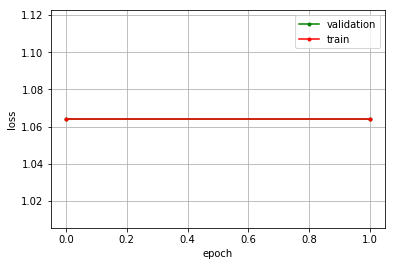

<Figure size 432x288 with 0 Axes>

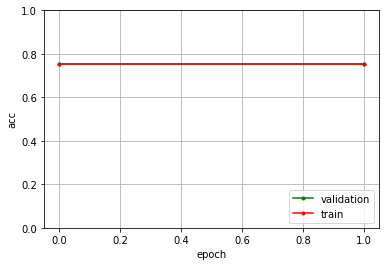

In [10]:
import glob
h5_path_list = glob.glob(os.path.join(out_dir, 'model_weight_optuna/**h5'))

# 出力層のニューラルネットワークに分岐がない場合のpredict
trained_model = keras.models.load_model(h5_path_list[0], compile=False)
out_predict_dir = os.path.join(out_dir, 'predict/sample_data')
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(trained_model, x_test, y_test, out_predict_dir)
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))

In [17]:
import glob
h5_list = glob.glob(os.path.join(out_dir, 'model_weight_optuna/**h5'))
h5_list

['output_test_optuna/100x100/model_weight_optuna/5016c4c5-7e55-438b-9873-f9900245792f.h5',
 'output_test_optuna/100x100/model_weight_optuna/738ec7fb-4565-4f10-8231-50c81427cf0a.h5',
 'output_test_optuna/100x100/model_weight_optuna/05722b1e-92c8-49a7-a964-0c8af6c9de67.h5',
 'output_test_optuna/100x100/model_weight_optuna/86bf3e0b-6aa7-4788-99bd-ee501b8e1f44.h5',
 'output_test_optuna/100x100/model_weight_optuna/0cf02891-d4c2-43dc-b581-9ca20093c02a.h5',
 'output_test_optuna/100x100/model_weight_optuna/395b7d5b-47c5-4553-a0ad-c3b76214e322.h5',
 'output_test_optuna/100x100/model_weight_optuna/c1658f99-9cf2-4446-9a33-381adc8d3ca6.h5',
 'output_test_optuna/100x100/model_weight_optuna/3e5e2eb9-3808-4443-a069-4f1aab3731d0.h5',
 'output_test_optuna/100x100/model_weight_optuna/7480f3a1-9a81-4fb6-a83d-0769682e4d88.h5',
 'output_test_optuna/100x100/model_weight_optuna/bf951278-5362-41d1-ad2e-8100992d858e.h5',
 'output_test_optuna/100x100/model_weight_optuna/500bba6a-9736-45b9-b313-dd0ff43582c3.h5',

In [ ]:
study.best_trial 

In [ ]:
study.trials # all trials

In [ ]:
len(study.trials)

In [ ]:
df.describe

In [ ]:
df.columns

In [ ]:
df.ix[2]

In [ ]:
np.min(d_cls.X_train)

In [ ]:
np.max(d_cls.X_train)